In [26]:
import os
import random
import numpy as np

from res_unet import SiameseNetwork
from PIL import Image
from tqdm.notebook import tqdm
from kornia.losses import DiceLoss
from losses import ContrastiveLoss
from utils import *
from datasets import MadoriOutlineDS, MadoriOutlineSiameseDS

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
from torch.nn import functional as F
from torch.nn import Module
from torch.optim import Adam

from matplotlib import pyplot as plt
%matplotlib inline

### global variables

In [2]:
img_dir = './data/image'
label_dir = './data/outline'
pair_madori_dir = './data/pair_madori'
checkpoint_dir = './checkpoint'

batch_size = 4
num_epochs = 100

train_file = './data/train.txt'
val_file = './data/val.txt'
test_file = './data/test.txt'
pair_madori_file = './data/pair_madori.txt'

loss_file = './epoch_losses.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### loss curve

In [ ]:
#show_plot(train_loss_history, val_loss_history)
import pandas as pd
df = pd.read_csv(loss_file, index_col=0)
df.iloc[20:].plot(figsize=(15,5), grid=True, title='loss curves of training & validation')
plt.show()

### test

In [ ]:
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(f'{checkpoint_dir}/best_val.pth'))
test_dl = DataLoader(MadoriOutlineSiameseDS(test_file), batch_size=1, shuffle=False)

In [ ]:
model.eval()
test_results_0 = []
test_results_1 = []
with torch.no_grad():
    for i, batch in enumerate(test_dl):
        #if i > 3: break
        
        # copy tensor to gpu
        img1, label1, img2, label2, is_diff = batch
        img1, label1 = img1.to(device), label1.to(device)
        img2, label2 = img2.to(device), label2.to(device)
        is_diff = is_diff.to(device)

        # predict
        output_unet1, output_unet2, output1, output2 = model(img1, img2)
        
        # unet prediction check
        output_unet1, output_unet2 = F.softmax(output_unet1, dim=1), F.softmax(output_unet2, dim=1)
        
        ones = torch.ones((256, 256))
        zeros = torch.zeros((256, 256))
        
        img1, img2 = img1.cpu(), img2.cpu()
        output_unet1, output_unet2 = output_unet1.cpu(), output_unet2.cpu()
        #imshow2(img1[0], torch.where(output_unet1[0,1] > 0.5, ones, zeros))
        #imshow2(img2[0], torch.where(output_unet2[0,1] > 0.5, ones, zeros))
        
        # siamese prediction check
        euclidean_distance = F.pairwise_distance(output1, output2)
        #print(f'label: {is_diff.item()}, pred distance: {euclidean_distance.item()}')
        if is_diff.item() == 1.0:
            test_results_1 += [euclidean_distance.item()]
        else:
            test_results_0 += [euclidean_distance.item()]

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(test_results_0, label='test_results_0')
plt.plot(test_results_1, label='test_results_1')
plt.legend()
plt.grid()
plt.plot()

### pair test

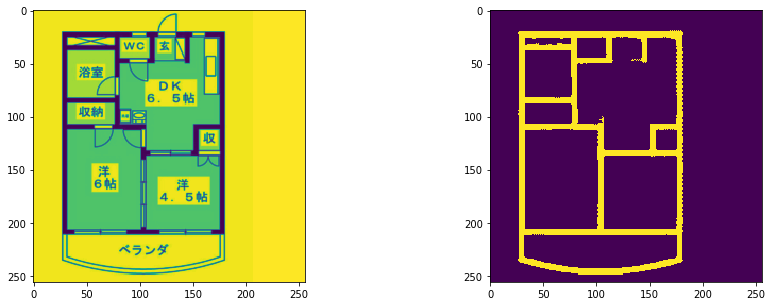

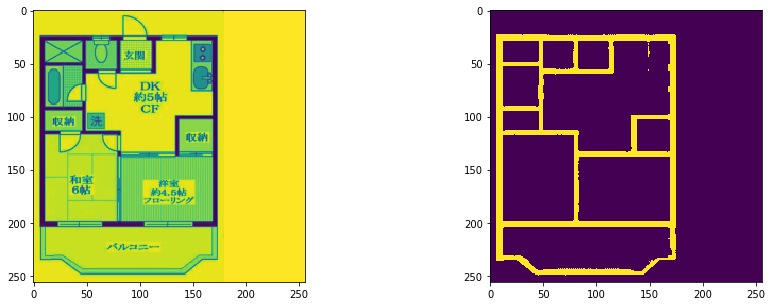

label: 0, pred distance: 5.922981262207031


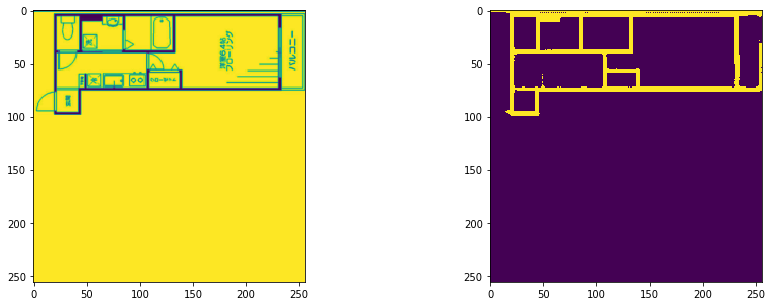

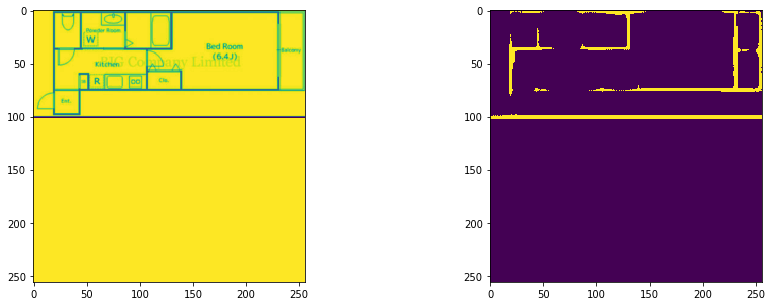

label: 0, pred distance: 3.8868494033813477


In [3]:
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(f'{checkpoint_dir}/best_val.pth'))
pair_test_dl = DataLoader(MadoriOutlineSiameseDS(pair_madori_file, pair_test=True), batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for i, batch in enumerate(pair_test_dl):
        #if i > 0: continue
        # copy tensor to gpu
        img1, img2 = batch
        img1, img2 = img1.to(device), img2.to(device)

        # predict
        output_unet1, output_unet2, output1, output2 = model(img1, img2)
        
        # unet prediction check
        output_unet1, output_unet2 = F.softmax(output_unet1, dim=1), F.softmax(output_unet2, dim=1)
        
        ones = torch.ones((256, 256))
        zeros = torch.zeros((256, 256))
        
        img1, img2 = img1.cpu(), img2.cpu()
        output_unet1, output_unet2 = output_unet1.cpu(), output_unet2.cpu()
        imshow2(img1[0,0], torch.where(output_unet1[0,1] > 0.5, ones, zeros))
        imshow2(img2[0,0], torch.where(output_unet2[0,1] > 0.5, ones, zeros))
        
        # siamese prediction check
        euclidean_distance = F.pairwise_distance(output1, output2)
        print(f'label: {0}, pred distance: {euclidean_distance.item()}')

In [18]:
im = Image.open('data/pair_madori/001_b.png').convert('L')

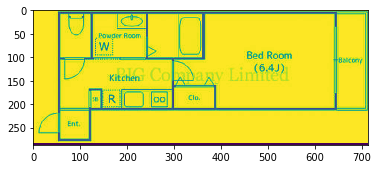

In [19]:
plt.imshow(im)

In [24]:
arr = np.asarray(im)
arr = np.where(arr<120, 0, arr)

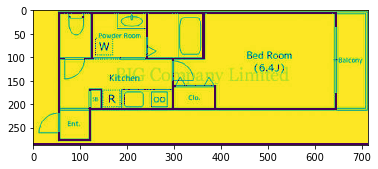

In [25]:
plt.imshow(arr)

In [36]:
t= torchvision.transforms.RandomAffine(degrees=0, fillcolor=255)(im)

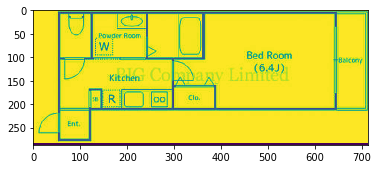

In [37]:
plt.imshow(t)